# Исследование объявлений о продаже квартир

Имеются данные о продаже квартир в Санкт-Петербурге и окресностях за несколько лет, нужно провести их анализ и выявить закономерности.

**Цель исследования** - определить, какие факторы влияют на формирование стоимости жилья. 


Эта информация позволит построить автоматизировнную систему для отслеживания аномалий и мошеннических действий.

Нужно определить, влияет ли на цену квартиры:
* общая площадь
* жилая площадь
* площадь кухни
* количество комнат
* этаж
* время размещения объявления (день, месяц, год)
* расстояние до центра города

Исследование будет проходить в несколько этапов:
* обзор данных
* предобработка данных (выявление и устранение пропусков, дубликатов, подозрительных значений, обогащение данных)
* проверка гипотез (с использованием сводных таблицы и графиков)

In [41]:
# Загружаю данные и смотрю, что получилось.
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

data = pd.read_csv('https://code.s3.yandex.net/datasets/real_estate_data.csv', sep='\t')
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


In [21]:
# Смотрю общую информацию о датафрейме.
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

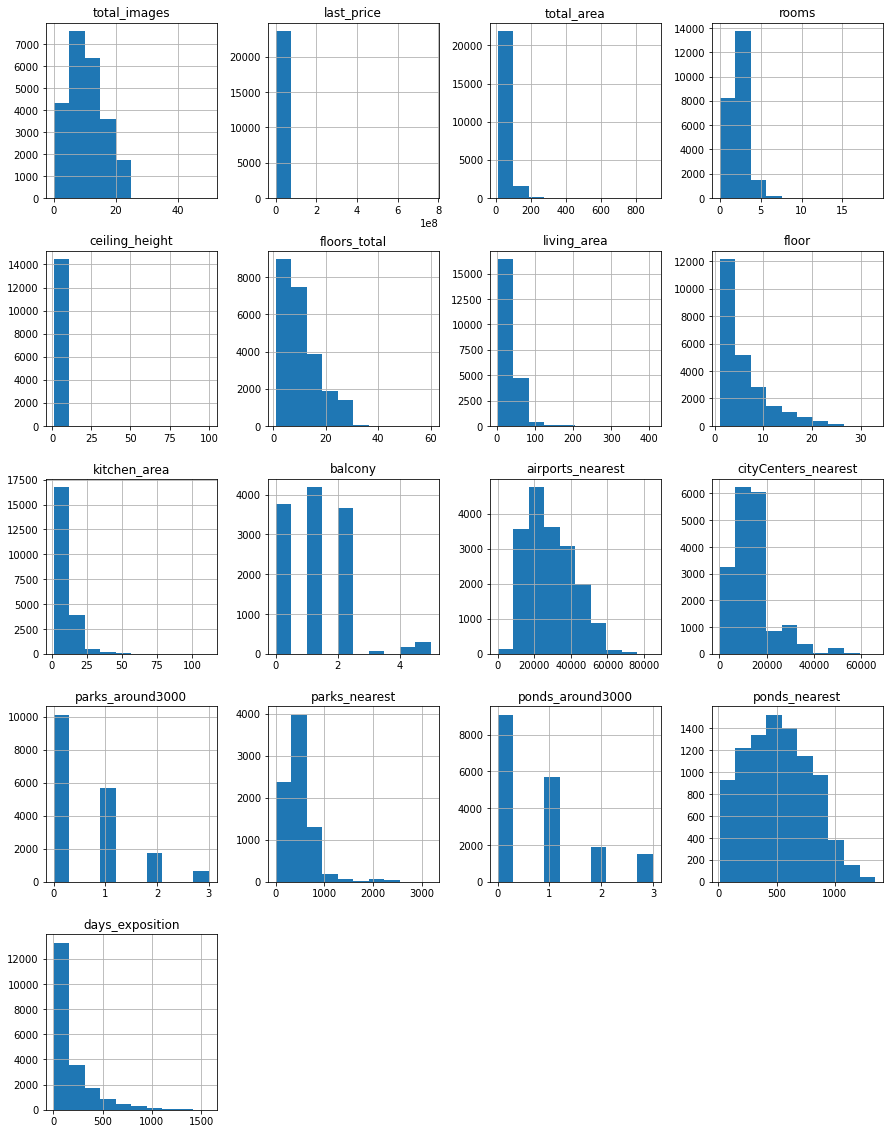

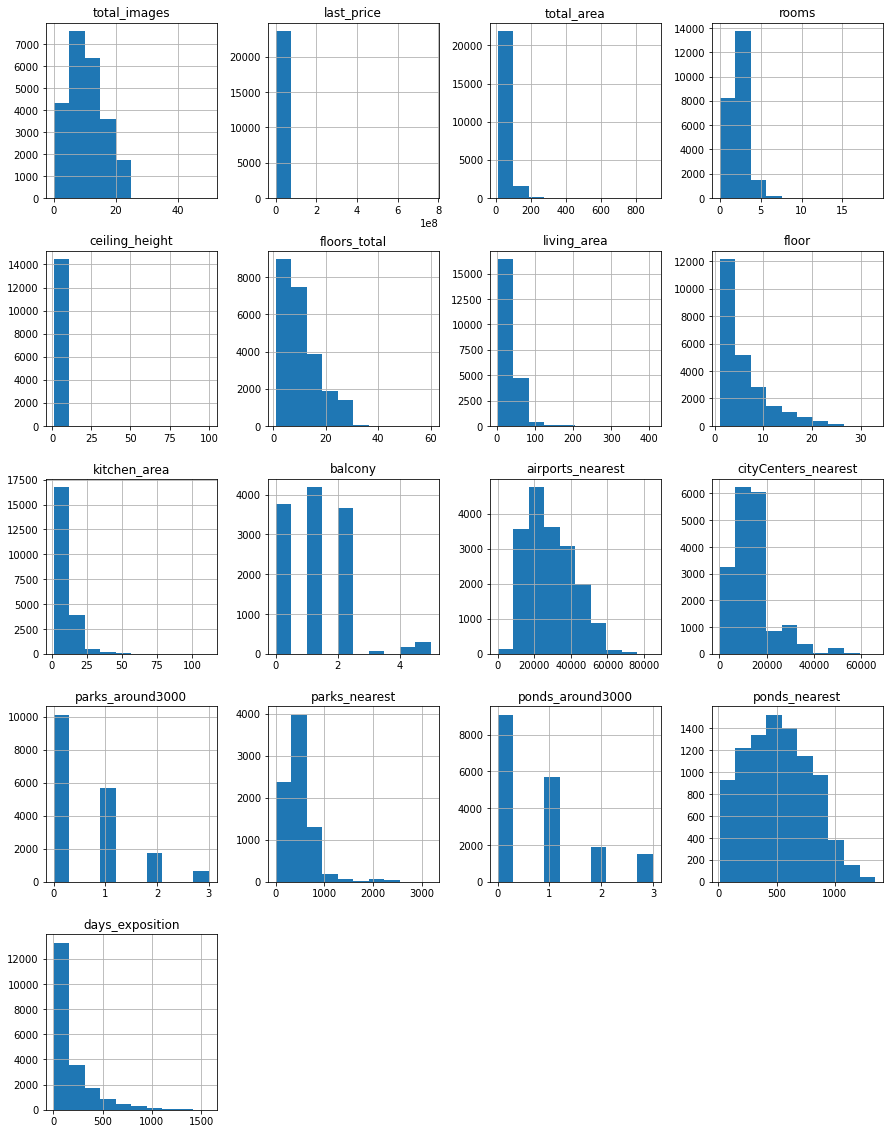

In [22]:
# Смотрю, как распределены значения в столбцах.
data.hist(figsize=(15, 20))
plt.show(0)

### Предобработка данных

In [23]:
# Проверяю количество пропусков данных.
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

In [24]:
# В столбцах 'balcony', 'parks_around3000', 'ponds_around3000' содержатся данные о количестве балконов, парков и прудов
# соответственно, часть значений пропущенно. Смфотрим, какие значения имеются в этих столбцах.
print(data['balcony'].unique())
print(data['parks_around3000'].unique())
print(data['ponds_around3000'].unique())

[nan  2.  0.  1.  5.  4.  3.]
[ 1.  0.  2. nan  3.]
[ 2.  0.  3.  1. nan]


In [25]:
# Будем считать, что отсутствие значения равно отсутствию явления, и заполним пустые строки нулями. 
# Также изменим тип данных с дробного на вещественный, т.к. количество балконов, парков и прудов может быть только
# целочисленным.

data['balcony'] = data['balcony'].fillna(0).astype('int')
data['parks_around3000'] = data['parks_around3000'].fillna(0).astype('int')
data['ponds_around3000'] = data['ponds_around3000'].fillna(0).astype('int')



In [26]:
# Узнаем количество строк с незаполненной жилой и кухонной площадью.
len(data[data['living_area'].isna() | data['kitchen_area'].isna()])

2717

In [27]:
# Строк достаточно много, попробуем заполнить их характерными значениями.
# Узнаем медианные значения площадей, а также доли кухонной и жилой площадей в общей площади квартир.

print(data['total_area'].median())
print(data['living_area'].median())
print(data['kitchen_area'].median())

living_area_part = data['living_area'].median() / data['total_area'].median()
kitchen_area_part = data['kitchen_area'].median() /data['total_area'].median()

print('Доля жилой площади', living_area_part)
print('Доля кухонной площади', kitchen_area_part)

# Попробуем сделать более точный расчет, рассчитав медиану долей. Значения получаются примерно такие же, с разницей в десятые
# доли процента. Чтобы не плодить столбцы и не громоздить расчеты, воспользуемся первыми результатами.№
#data['living_area_part'] = data['living_area'] / data['total_area']
#print(data['living_area_part'].median())
#data['kitchen_area_part'] = data['kitchen_area'] / data['total_area']
#print(data['kitchen_area_part'].median())



52.0
30.0
9.1
Доля жилой площади 0.5769230769230769
Доля кухонной площади 0.175


In [28]:
# Заполним пустые значения медианными долями от общей площади квартиры.
data['living_area'] = data['living_area'].fillna(data['total_area'] * living_area_part).round(1)
data['kitchen_area'] = data['kitchen_area'].fillna(data['total_area'] * kitchen_area_part).round(1)


In [29]:
# Проверим результат и еще раз посмотрим, где остались пустые строки.
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area                 0
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area                0
balcony                     0
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000            0
parks_nearest           15620
ponds_around3000            0
ponds_nearest           14589
days_exposition          3181
dtype: int64

In [30]:
# Проверим предположение о том, что пустые строки в столбцах 'parks_nearest' и  'ponds_nearest' соответствуют отсутствию
#  парка или пруда на расстоянии 3000м.
print(data.query('parks_around3000 == 0')['parks_nearest'].unique())
print(data.query('ponds_around3000 == 0')['ponds_nearest'].unique())

# Посмотрим, много ли строк со значениями.
print(data.query('parks_around3000 == 0')['parks_nearest'].value_counts())


[  nan 3064. 3190. 3013.]
[nan]
3190.0    2
3064.0    1
3013.0    1
Name: parks_nearest, dtype: int64


In [31]:
# Проверим, есть ли похожая закономерность у пропусков в расстояниях до центра города и аэропорта.

print(data['airports_nearest'].min())
print(data['airports_nearest'].max())

print(data['cityCenters_nearest'].min())
print(data['cityCenters_nearest'].max())



0.0
84869.0
181.0
65968.0




В столбцах с расстояниями до ближайшего пруда или парка пропущенные значения практически соответствуют отсутсвию поблизости парка или пруда (за исключением 4-х строк, значения которых близки к референсным 3000м). 

Судя по всему, столбцы с данными о высоте потолков, количестве этажей в доме, жилой площади, апартаментах и площади кухни ('ceiling_height', 'living_area', 'is_apartment', 'kitchen_area') - это столбцы добавленные пользователем, поэтому отнесем эти пропуски к человеческому фактору.

Столбцы же с данными о расстояниях до центра и аэропорта относятся к картографическим данным. Не похоже, что данные пропущены из-за слишком большого расстояния (как с парками и прудами). Вряд ли существует квартиры, у которых невозможно рассчитать эти расстояния. Кроме того, их примерно одинаковое количество - 5,5 тысяч. Возможно, что пропуски в этих данных появились в результате ошибки при выгрузке.

Что касается пропусков в столбце 'days_exposition', скорее всего данные о том, сколько дней было размещено объявление, заполнялись автоматически. Может ли быть такое, что часть квартир до сих пор продается?


In [39]:
# Заполним пропуски в столбцах с высотой потолков медианным значениям по населенным пунктам.
for locality_name in data['locality_name'].unique():
    median = data.loc[data['locality_name'] == locality_name, 'ceiling_height'].median()
    data.loc[(data['ceiling_height'].isna()) & (data['locality_name'] == locality_name), 'ceiling_height'] = median

# Заполним оставшиеся пропуски медианой по Лен. области.
data.loc[data['ceiling_height'].isna(), 'ceiling_height'] = data['ceiling_height'].median()


In [42]:
# Заполним расстояния до центра и до аэропорта медианным значением по населенным пунктам.
for locality_name in data['locality_name'].unique():
    median_airports = data.loc[data['locality_name'] == locality_name, 'airports_nearest'].median()
    median_cityCenters = data.loc[data['locality_name'] == locality_name, 'cityCenters_nearest'].median()
    data.loc[(data['airports_nearest'].isna()) & (data['locality_name'] == locality_name), 'airports_nearest'] = median_airports
    data.loc[(data['cityCenters_nearest'].isna()) & (data['locality_name'] == locality_name), 'cityCenters_nearest'] = median_cityCenters

In [43]:
# Посмотрим, что получилось.
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5394
cityCenters_nearest      5394
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

In [44]:
# Еще раз посмотрим на имеющиеся типы данных.
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

In [45]:
# Переведем из дробного в вещественный тип.
data['last_price'] = data['last_price'].astype('int')
data['floors_total'] = pd.to_numeric(data['floors_total'], errors='ignore')
data['days_exposition'] = pd.to_numeric(data['days_exposition'], errors='ignore')


Столбец 'last_price' содержит данные о цене на квартиру, она исчисляется в сотнях тысяч и миллионах, при таких больших цифрах для анализа не имеет значения дробная часть. Кроме того, без дробной части удобнее воспринимать большие числа.

Столбец'floors_total' содержит данные о количестве этажей в доме это может быть только целое число, поэтому не имеет смысла хранить эти данные в дробном формате.

Столбец 'days_exposition' содержит данные о количестве дней, когда квартира была выставлена на продажу. Количество дней в принципе может быть дробным, но в нашем наборе данных все эти числа не содержат цифр после запятой.

#### Обработка дубликатов

In [46]:
# Сразу приведем столбец с названиями населенных пунктов к нижнему регистру и изучим его содержимое.
print(data['locality_name'].unique())



['Санкт-Петербург' 'посёлок Шушары' 'городской посёлок Янино-1'
 'посёлок Парголово' 'посёлок Мурино' 'Ломоносов' 'Сертолово' 'Петергоф'
 'Пушкин' 'деревня Кудрово' 'Коммунар' 'Колпино'
 'поселок городского типа Красный Бор' 'Гатчина' 'поселок Мурино'
 'деревня Фёдоровское' 'Выборг' 'Кронштадт' 'Кировск'
 'деревня Новое Девяткино' 'посёлок Металлострой'
 'посёлок городского типа Лебяжье' 'посёлок городского типа Сиверский'
 'поселок Молодцово' 'поселок городского типа Кузьмоловский'
 'садовое товарищество Новая Ропша' 'Павловск' 'деревня Пикколово'
 'Всеволожск' 'Волхов' 'Кингисепп' 'Приозерск' 'Сестрорецк'
 'деревня Куттузи' 'посёлок Аннино' 'поселок городского типа Ефимовский'
 'посёлок Плодовое' 'деревня Заклинье' 'поселок Торковичи'
 'поселок Первомайское' 'Красное Село' 'посёлок Понтонный' 'Сясьстрой'
 'деревня Старая' 'деревня Лесколово' 'посёлок Новый Свет' 'Сланцы'
 'село Путилово' 'Ивангород' 'Мурино' 'Шлиссельбург' 'Никольское'
 'Зеленогорск' 'Сосновый Бор' 'поселок Новый Све

In [47]:
# Заменим ё на е.
data['locality_name'] = data['locality_name'].str.lower().str.replace('ё','е')

# Замеиним совпадающие названия.
data['locality_name'] = data['locality_name'].replace('поселок мурино','мурино')
data['locality_name'] = data['locality_name'].replace('поселок любань','любань')
data['locality_name'] = data['locality_name'].str.replace('поселок городского типа','городской поселок')

# Посмотрим, что получится.
data['locality_name'].sort_values().unique()

array(['бокситогорск', 'волосово', 'волхов', 'всеволожск', 'выборг',
       'высоцк', 'гатчина', 'городской поселок большая ижора',
       'городской поселок будогощь', 'городской поселок важины',
       'городской поселок виллози', 'городской поселок вознесенье',
       'городской поселок вырица', 'городской поселок дружная горка',
       'городской поселок дубровка', 'городской поселок ефимовский',
       'городской поселок имени морозова',
       'городской поселок имени свердлова',
       'городской поселок кондратьево', 'городской поселок красный бор',
       'городской поселок кузнечное', 'городской поселок кузьмоловский',
       'городской поселок лебяжье', 'городской поселок лесогорский',
       'городской поселок мга', 'городской поселок назия',
       'городской поселок никольский', 'городской поселок новоселье',
       'городской поселок павлово', 'городской поселок приладожский',
       'городской поселок рахья', 'городской поселок рощино',
       'городской поселок рябово'

#### Обработаем аномалии.

In [ ]:
# Проверим значения в столбце с высотой потолков.
sorted(data['ceiling_height'].unique())



[1.0,
 1.2,
 1.75,
 2.0,
 2.2,
 2.25,
 2.3,
 2.34,
 2.4,
 2.45,
 2.46,
 2.47,
 2.48,
 2.49,
 2.5,
 2.51,
 2.5149999999999997,
 2.52,
 2.525,
 2.53,
 2.54,
 2.55,
 2.5549999999999997,
 2.5599999999999996,
 2.56,
 2.57,
 2.575,
 2.58,
 2.59,
 2.5999999999999996,
 2.6,
 2.61,
 2.615,
 2.62,
 2.625,
 2.63,
 2.64,
 2.65,
 2.6500000000000004,
 2.66,
 2.67,
 2.675,
 2.68,
 2.69,
 2.7,
 2.71,
 2.72,
 2.725,
 2.73,
 2.74,
 2.75,
 2.76,
 2.77,
 2.78,
 2.79,
 2.8,
 2.81,
 2.82,
 2.83,
 2.84,
 2.85,
 2.86,
 2.87,
 2.88,
 2.89,
 2.9,
 2.91,
 2.92,
 2.93,
 2.94,
 2.95,
 2.96,
 2.97,
 2.98,
 2.99,
 3.0,
 3.01,
 3.02,
 3.03,
 3.04,
 3.05,
 3.06,
 3.07,
 3.08,
 3.09,
 3.1,
 3.11,
 3.12,
 3.13,
 3.14,
 3.15,
 3.16,
 3.17,
 3.18,
 3.2,
 3.21,
 3.22,
 3.23,
 3.24,
 3.25,
 3.26,
 3.27,
 3.28,
 3.29,
 3.3,
 3.31,
 3.32,
 3.33,
 3.34,
 3.35,
 3.36,
 3.37,
 3.38,
 3.39,
 3.4,
 3.42,
 3.43,
 3.44,
 3.45,
 3.46,
 3.47,
 3.48,
 3.49,
 3.5,
 3.51,
 3.52,
 3.53,
 3.54,
 3.55,
 3.56,
 3.57,
 3.58,
 3.59,
 3.6,
 3.6

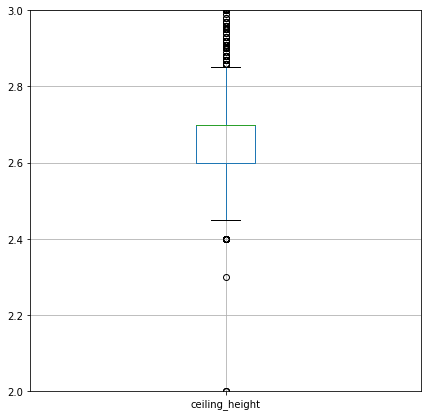

In [ ]:
import matplotlib.pyplot as plt
# Посмотрим, как распределяются значения.
data.boxplot('ceiling_height', figsize=(7,7))
plt.ylim(2,3);

In [48]:
# Я погуглила и обнаружила, что есть квартиры с высокими потолками, но их очень мало. 
# А квартиры с потолками более 6 метров очень редкие. Кроме того, для меня совсем не логично предположение, что
# 25,0 м - это скорее всего 2,5 м. Отфильтровав строки по условию, я обнаружила, что строк с подозрительными значениями высоты
# потолка всего 32. Мне кажется, что их легче удалить, чем пытаться поправить на ненадежные данные. Потолки менее 2м тоже 
# выглядят неправдоподобно.

data[(data['ceiling_height'] < 2) | (data['ceiling_height'] > 6)]



,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
355,17,3600000,55.2,2018-07-12T00:00:00,2,25.00,5.0,32.0,2,False,...,NaN,2.0,гатчина,NaN,NaN,NaN,NaN,NaN,NaN,259.0
3148,14,2900000,75.0,2018-11-12T00:00:00,3,32.00,3.0,53.0,2,NaN,...,8.00,NaN,волхов,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3474,3,1400000,30.0,2018-03-16T00:00:00,1,8.00,5.0,15.3,2,False,...,7.30,NaN,деревня нурма,NaN,NaN,NaN,NaN,NaN,NaN,125.0
4643,0,4300000,45.0,2018-02-01T00:00:00,2,25.00,9.0,30.0,2,NaN,...,7.00,1.0,санкт-петербург,12016.0,13256.0,1.0,658.0,1.0,331.0,181.0
4876,7,3000000,25.0,2017-09-27T00:00:00,0,27.00,25.0,17.0,17,NaN,...,NaN,2.0,мурино,NaN,NaN,NaN,NaN,NaN,NaN,28.0
5076,0,3850000,30.5,2018-10-03T00:00:00,1,24.00,5.0,19.5,1,True,...,5.50,NaN,санкт-петербург,29686.0,8389.0,3.0,397.0,1.0,578.0,7.0
5246,0,2500000,54.0,2017-10-13T00:00:00,2,27.00,5.0,30.0,3,NaN,...,9.00,2.0,деревня мины,NaN,NaN,NaN,NaN,NaN,NaN,540.0
5669,4,4400000,50.0,2017-08-08T00:00:00,2,26.00,9.0,21.3,3,NaN,...,7.00,2.0,санкт-петербург,28981.0,10912.0,1.0,305.0,0.0,NaN,267.0
5712,5,1500000,42.8,2017-08-14T00:00:00,2,1.20,2.0,27.5,1,NaN,...,5.20,NaN,городской поселок мга,NaN,NaN,NaN,NaN,NaN,NaN,248.0
5807,17,8150000,80.0,2019-01-09T00:00:00,2,27.00,36.0,41.0,13,NaN,...,12.00,5.0,санкт-петербург,18732.0,20444.0,0.0,NaN,3.0,80.0,38.0


In [49]:
data[~((data['ceiling_height'] < 2) | (data['ceiling_height'] > 6))]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000,108.00,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.00,NaN,санкт-петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000,40.40,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.00,2.0,поселок шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000,56.00,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.30,0.0,санкт-петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000,159.00,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,санкт-петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000,100.00,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.00,NaN,санкт-петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23694,9,9700000,133.81,2017-03-21T00:00:00,3,3.70,5.0,73.3,3,NaN,...,13.83,NaN,санкт-петербург,24665.0,4232.0,1.0,796.0,3.0,381.0,NaN
23695,14,3100000,59.00,2018-01-15T00:00:00,3,NaN,5.0,38.0,4,NaN,...,8.50,NaN,тосно,NaN,NaN,NaN,NaN,NaN,NaN,45.0
23696,18,2500000,56.70,2018-02-11T00:00:00,2,NaN,3.0,29.7,1,NaN,...,NaN,NaN,село рождествено,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23697,13,11475000,76.75,2017-03-28T00:00:00,2,3.00,17.0,NaN,12,NaN,...,23.30,2.0,санкт-петербург,39140.0,10364.0,2.0,173.0,3.0,196.0,602.0


In [50]:
# Удалим подозрительные строки.
data = data[~((data['ceiling_height'] < 2) | (data['ceiling_height'] > 6))]


In [51]:
# Проверим столбец с общей площадью квартир.
print(data['total_area'].min())
print(data['total_area'].max())
print(data['total_area'].median())

# Посмотрим количество квартир с очень маленькой и очень большой площадью.
print(len(data.query('total_area < 20')))
print(len(data.query('total_area > 300')))

12.0
900.0
52.0
27
61


In [52]:
## Чтобы сделать выборку более однородной, удалим квартиры с очень маленькой и очень большой площадью 
# и посмотрим, как изменились показатели.
data = data[(data['total_area'] > 20) & (data['total_area'] < 200)]

print(data['total_area'].min())
print(data['total_area'].max())
print(data['total_area'].median())


20.1
199.2
52.0


In [53]:
# Посмотрим столбец с жилой площадью.
print(data['living_area'].min())
print(data['living_area'].max())
print(data['living_area'].median())
#Проверим квартиры с очень маленькими значениями жилой площади.
data.query('living_area < 10')


2.0
164.7
30.0


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
114,5,4000000,21.40,2019-02-07T00:00:00,1,2.90,8.0,8.3,7,NaN,...,6.3,NaN,санкт-петербург,27089.0,5791.0,2.0,488.0,1.0,286.0,NaN
680,14,7200000,43.00,2017-10-31T00:00:00,1,NaN,8.0,9.0,2,NaN,...,23.0,NaN,санкт-петербург,23900.0,5232.0,1.0,2137.0,1.0,933.0,296.0
1326,8,8100000,52.00,2017-01-29T00:00:00,2,2.70,25.0,9.0,15,NaN,...,32.0,2.0,санкт-петербург,35555.0,15561.0,0.0,NaN,1.0,1180.0,337.0
2309,10,4200000,62.40,2017-06-15T00:00:00,2,2.60,9.0,8.4,6,NaN,...,41.0,2.0,поселок шушары,23662.0,29448.0,0.0,NaN,0.0,NaN,111.0
3242,7,4440000,41.00,2017-07-02T00:00:00,1,NaN,17.0,3.0,17,NaN,...,11.0,NaN,санкт-петербург,19272.0,13073.0,0.0,NaN,0.0,NaN,216.0
4100,17,5300000,34.80,2017-06-19T00:00:00,1,2.70,23.0,9.0,15,NaN,...,17.1,0.0,санкт-петербург,33626.0,13495.0,0.0,NaN,0.0,NaN,30.0
7312,8,3400000,27.00,2018-02-21T00:00:00,2,2.50,15.0,9.0,4,NaN,...,16.0,NaN,санкт-петербург,50246.0,16444.0,1.0,617.0,0.0,NaN,NaN
8325,9,4800000,52.00,2017-10-25T00:00:00,2,NaN,5.0,9.0,2,NaN,...,6.0,1.0,санкт-петербург,33358.0,13171.0,0.0,NaN,2.0,118.0,119.0
13915,20,6350000,52.00,2018-02-06T00:00:00,2,3.00,6.0,2.0,2,NaN,...,9.0,NaN,санкт-петербург,32453.0,6521.0,0.0,NaN,1.0,1012.0,91.0
15833,20,4600000,33.00,2017-01-01T00:00:00,1,2.70,22.0,9.0,12,NaN,...,14.3,1.0,санкт-петербург,33803.0,13671.0,0.0,NaN,0.0,NaN,511.0


In [54]:
# Подозрительно относительно общей площади выглядят жилые площади от 8 м и меньше. 
# Скорее всего, произошла какая-то ошибка в заполнении, т.к. квартиры нормальной площади. Удалим эти значения.
data = data.query('living_area > 8')

In [55]:
# Также проверим площадь кухни.
print(data['kitchen_area'].min())
print(data['kitchen_area'].max())
print(data['kitchen_area'].median())

# Проверим квартиры с очень маленькими значениями кухонной площади.
data.query('kitchen_area < 3')

# Судя по всему, маленькие кухни расположены в маленьких квартирах, все в порядке.

1.3
93.2
9.0


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
906,15,2600000,27.00,2017-07-10T00:00:00,1,2.75,23.0,18.0,18,NaN,...,2.00,0.0,санкт-петербург,22131.0,17459.0,0.0,NaN,1.0,411.0,10.0
6262,9,3100000,24.00,2018-06-25T00:00:00,2,3.00,5.0,16.0,5,NaN,...,2.00,NaN,санкт-петербург,31960.0,4914.0,2.0,426.0,1.0,936.0,54.0
7950,3,5967734,66.40,2017-02-07T00:00:00,2,NaN,4.0,44.4,2,False,...,2.89,NaN,санкт-петербург,44870.0,20802.0,0.0,NaN,0.0,NaN,335.0
9138,17,2920000,23.29,2018-12-12T00:00:00,1,NaN,3.0,21.0,1,NaN,...,2.00,NaN,санкт-петербург,19506.0,4008.0,0.0,NaN,2.0,45.0,107.0
11033,6,5350000,32.00,2016-04-20T00:00:00,1,NaN,14.0,16.0,10,NaN,...,2.00,0.0,санкт-петербург,19008.0,3953.0,0.0,NaN,1.0,69.0,210.0
16367,2,2720000,25.70,2017-10-30T00:00:00,1,NaN,19.0,22.6,11,NaN,...,2.00,NaN,санкт-петербург,14472.0,13268.0,0.0,NaN,0.0,NaN,109.0
17834,5,2940000,34.70,2017-10-09T00:00:00,1,NaN,26.0,15.5,14,NaN,...,2.30,1.0,мурино,NaN,NaN,NaN,NaN,NaN,NaN,318.0
20217,7,4250000,28.50,2019-05-01T00:00:00,1,2.80,14.0,19.5,10,NaN,...,1.30,NaN,санкт-петербург,37199.0,12721.0,0.0,NaN,0.0,NaN,NaN


In [56]:
# Проверим столбец с ценами.
sorted(data['last_price'].unique())

[12190,
 430000,
 450000,
 470000,
 480000,
 490000,
 500000,
 520000,
 530000,
 550000,
 560000,
 565000,
 580000,
 590000,
 600000,
 620000,
 630000,
 650000,
 660000,
 680000,
 690000,
 700000,
 720000,
 730000,
 740000,
 750000,
 770000,
 777000,
 780000,
 790000,
 799000,
 800000,
 820000,
 850000,
 860000,
 869000,
 870000,
 880000,
 890000,
 900000,
 910000,
 920000,
 950000,
 970000,
 980000,
 990000,
 995000,
 999000,
 999999,
 1000000,
 1010000,
 1020000,
 1030000,
 1050000,
 1060000,
 1070000,
 1080000,
 1090000,
 1099000,
 1100000,
 1110000,
 1130000,
 1150000,
 1170000,
 1180000,
 1190000,
 1199000,
 1200000,
 1220000,
 1230000,
 1250000,
 1260000,
 1270000,
 1280000,
 1290000,
 1300000,
 1310000,
 1315000,
 1320000,
 1330000,
 1350000,
 1353000,
 1360000,
 1370000,
 1380000,
 1390000,
 1399000,
 1400000,
 1420000,
 1430000,
 1440000,
 1449900,
 1450000,
 1470000,
 1480000,
 1490000,
 1499000,
 1500000,
 1510000,
 1540000,
 1550000,
 1555000,
 1560000,
 1570000,
 1580000,


In [57]:
data.query('last_price > 100000000')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
1436,19,330000000,190.0,2018-04-04T00:00:00,3,3.50,7.0,95.0,5,NaN,...,40.0,NaN,санкт-петербург,23011.0,1197.0,3.0,519.0,3.0,285.0,233.0
4996,20,124000000,124.5,2017-10-12T00:00:00,4,3.00,4.0,67.2,2,False,...,20.0,NaN,санкт-петербург,20399.0,1722.0,3.0,302.0,3.0,172.0,45.0
16647,15,122000000,145.0,2017-04-25T00:00:00,3,3.30,6.0,36.0,2,NaN,...,72.0,NaN,санкт-петербург,33931.0,7023.0,2.0,478.0,3.0,250.0,335.0
17912,17,135000000,166.0,2019-02-07T00:00:00,3,3.30,7.0,52.0,1,NaN,...,64.0,NaN,санкт-петербург,32863.0,5955.0,2.0,230.0,3.0,215.0,NaN
20264,17,119000000,187.6,2017-07-10T00:00:00,4,6.00,7.0,147.0,7,NaN,...,15.6,NaN,санкт-петербург,26902.0,5605.0,3.0,484.0,1.0,305.0,259.0
22831,18,289238400,187.5,2019-03-19T00:00:00,2,3.37,6.0,63.7,6,NaN,...,30.2,NaN,санкт-петербург,22494.0,1073.0,3.0,386.0,3.0,188.0,NaN


In [58]:
# Заметим, что одна квартира стоит неправдоподобно дешево и всего 6 квартир дороже 100 000 000 рублей. Удалим эти строки.
data = data.query('(last_price >= 13000) & (last_price < 100000000)')

In [59]:
# Посмотрим столбец этажей. Все значения в порядке, подозрительных нет.
sorted(data['floor'].unique())

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33]

In [60]:
# Посмотрим расстояния до аэропорта, я заметила небольшую странность в минимальном значении.
data.query('airports_nearest < 100')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
21085,0,7000000,34.7,2018-09-23T00:00:00,1,2.7,9.0,19.8,3,NaN,...,6.0,2.0,санкт-петербург,0.0,22801.0,0.0,NaN,0.0,NaN,60.0


In [61]:
# Удалим подозрительное значение.
data = data.query('airports_nearest > 100')

In [62]:
len(data)

16746

In [63]:
# Проверим на явные дубликаты.
data.duplicated().sum()

0

После более подробного рассмотрения данных, были обнаружены аномалии в столбцах с высотой потолков, общей площадью квартир, жилой площадью, ценой квартиры и расстоянием до аэропорта. 

Высота потолков встречалась как очень малая, так и очень большая (меньше 2-х м и больше 6-ти м соответственно). Удалим эти значения, т.к. они относятся к редким или подозрительным.

Также встречались квартиры с очень большой и очень маленькой площадью, вряд ли это ошибка, т.к. квартиры бывают очень разных размеров, но это редкие значения, которые могли искажать значения в будущих расчетах.

Проблемные значения попадались и в столбце с жилой площадью, встречалась жилая площадь 2 кв.м при общей площади квартиры 50 кв.м. Такое вряд ли возможно, поэтому строки с аномальными значениями были удалены.

В ценах на квартиры также попалось подозрительно маленькое значение 12 000 рублей, это явная ошибка, строка удалена. К редким значениям я отнесла квартиры дороже 100 000 000 рублей, эти строки тоже удалены.

В расстояниях до аэропорта было значение 0 м, вряд ли это соответствует действительности.

### Добавление новых столбцов

In [64]:
# Добавим столбец с ценой за 1кв.м.
data['price_1sqm'] = data['last_price'] / data['total_area']

# Поменяем формат столбца с датой и добавим столбцы с днем недели, месяцем и годом публикации объявления.
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')
data['day'] = pd.DatetimeIndex(data['first_day_exposition']).weekday
data['month'] = pd.DatetimeIndex(data['first_day_exposition']).month
data['year'] = pd.DatetimeIndex(data['first_day_exposition']).year

# Добавим столбец с расстоянием до центра в километрах.
data['cityCenters_km'] = (data['cityCenters_nearest'] / 1000).round()

In [65]:
# Добавим столбец с категорией этажа. Для этого сначала напишем функцию, присваивающую тип этажа по значению.
def categorize_floor(row):
    floor = row['floor']
    last_floor = row['floors_total']
    if floor == 1:
        return 'первый'
    if floor == last_floor:
        return 'последний'
    return 'другой'


data['floor_type'] = data.apply(categorize_floor, axis=1)

In [66]:
# Посмотрим на новые столбцы.
data.sample(10)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_1sqm,day,month,year,cityCenters_km,floor_type
8165,6,3750000,57.0,2017-05-28,3,NaN,5.0,43.0,1,NaN,...,598.0,0.0,NaN,128.0,65789.473684,6,5,2017,8.0,первый
3733,16,4700000,34.1,2018-10-29,1,2.60,21.0,18.1,16,NaN,...,NaN,0.0,NaN,105.0,137829.912023,0,10,2018,12.0,другой
20966,6,4050000,50.0,2017-04-04,2,NaN,9.0,21.0,6,NaN,...,NaN,1.0,1064.0,113.0,81000.000000,1,4,2017,13.0,другой
7509,20,8500000,77.7,2018-09-03,3,3.10,5.0,42.9,5,NaN,...,324.0,2.0,146.0,85.0,109395.109395,0,9,2018,8.0,последний
5322,5,2350000,32.0,2017-09-28,1,NaN,6.0,16.2,5,NaN,...,NaN,0.0,NaN,475.0,73437.500000,3,9,2017,30.0,другой
21168,5,3250000,30.8,2015-11-08,1,NaN,9.0,17.8,5,False,...,45.0,0.0,NaN,267.0,105519.480519,6,11,2015,9.0,другой
5573,11,3650000,36.7,2017-07-02,1,2.65,9.0,15.8,2,NaN,...,NaN,0.0,NaN,85.0,99455.040872,6,7,2017,17.0,другой
2781,20,3770000,39.0,2017-04-07,1,NaN,23.0,18.0,16,NaN,...,NaN,1.0,390.0,481.0,96666.666667,4,4,2017,18.0,другой
20969,18,13300000,133.0,2015-02-11,4,3.00,5.0,58.0,2,NaN,...,NaN,1.0,534.0,1512.0,100000.000000,2,2,2015,5.0,другой
22729,20,12959000,73.1,2019-02-19,3,2.80,25.0,38.1,20,NaN,...,724.0,0.0,NaN,NaN,177277.701778,1,2,2019,13.0,другой


### Исследовательский анализ данных

#### Изучение параметры объектов.

<AxesSubplot:>

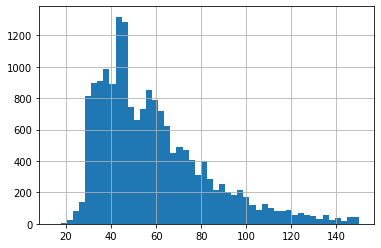

In [ ]:
data['total_area'].hist(bins=50, range=(15,150))

**Гистограмма распределения значений общей площади квартир.**

Наибольшее число продаваемых квартир небольшой площади, около 40 кв.м. Есть всплеск на значении 30 кв.м, это стандартная площадь однушки в хрущевке, самом популярном типе жилья.Также продается достаточно много квартир до 70 кв.м. Больших квартир, более 150 кв.м. очень мало.

<div class="alert alert-info"> Пик примерно на 45 кв.м, провал на 50 и далее подъем на 60 кв.м.
</div>

<AxesSubplot:>

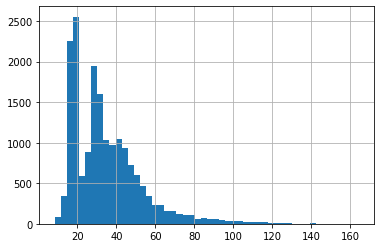

In [ ]:
data['living_area'].hist(bins=50)

**Гистограмма распределения значений жилой площади квартир.**

Пики распределения приходится на жилую площадь 15-20 кв.м. и 30 кв.м. Также достаточно много квартир с жилой площадбю до 50 кв.м. Это вполне соответствует распределению общей площади квартир.

<AxesSubplot:>

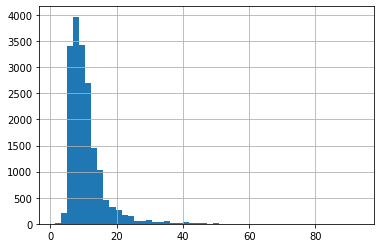

In [ ]:
data['kitchen_area'].hist(bins=50)

**Гистограмма распределения значений площади кухни.**

Наибольшее количество продаваемых квартир имеют кухни 5-10 кв.м. Квартир с кухнями более 20 кв.м. немного, а с кухнями больше 40 кв.м. практически нет.

<AxesSubplot:>

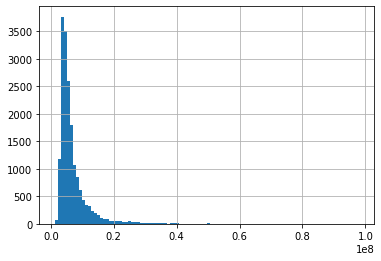

In [ ]:
data['last_price'].hist(bins=100)

**Гистограмма распределения стоимости квартир**

Основная масса квартир стоит до 10 млн. руб. Очень дорогих квартир практически нет в нашей выборке.


<AxesSubplot:>

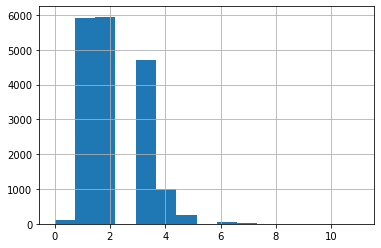

In [ ]:
data['rooms'].hist(bins=15)


**Гистограмма распределения количества комнат.**

В большинстве продаваемых квартир 1-2 комнаты. Более 6 комнат в квартире встречается крайне редко.

<AxesSubplot:>

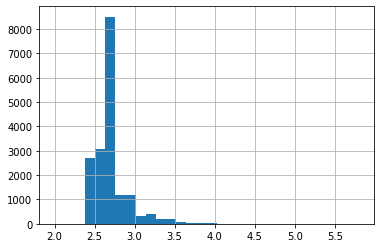

In [ ]:
data['ceiling_height'].hist(bins=30)

**Гистограмма распределения высоты потолков.**

В большинстве квартир, стандартные потолки - 2,5м. Также существует заметная доля квартир с потолками до 3м. А квартир с более высокими потолками мало.

<AxesSubplot:>

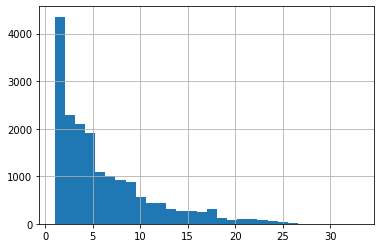

In [ ]:
data['floor'].hist(bins=30)


**Гистограмма распределения этажей.**

Большинство квартир в объявлениях расположены на 1-2 этажах, существенная доля кватир также расположена не выше 5 этажа. Квартиры, расположеные на этажах выше 15, встречаются редко.

<AxesSubplot:>

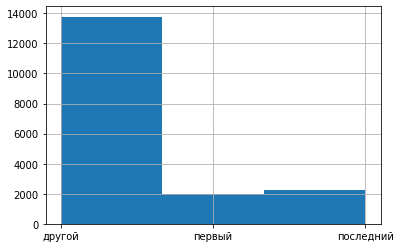

In [ ]:
data['floor_type'].hist(bins=3)

**Гистограмма распределения этажа квартир.**

Квартир, расположенных на первых и посдедних этажах, существенно меньше, чем квартир, расположенных на прочих этажах.

<AxesSubplot:>

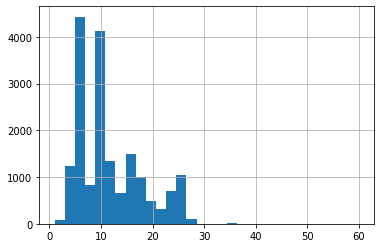

In [ ]:
data['floors_total'].hist(bins=30)

**Гистограмма распределения общей высотности домов.**

Пик гистограмм приходится на 5-ти и 10-ти этажные дома.

<AxesSubplot:>

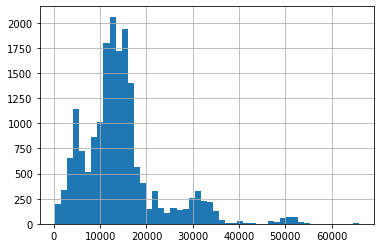

In [ ]:
data['cityCenters_nearest'].hist(bins=50)

**Гистограмма распределения расстояний до центра.**

Большинство квартир рассположены в 12 или 15 км от центра, но также есть некоторое количество квартир, расположенных в центре (с расстоянием до 2 км). Кроме того наблюдается некий всплеск на отметке 5 км.



<AxesSubplot:>

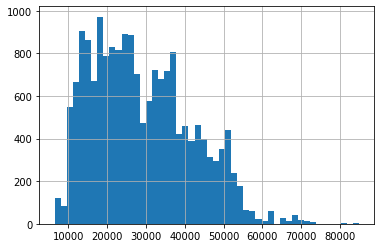

In [ ]:
data['airports_nearest'].hist(bins=50)

**Гистограмма распределения расстояний до аэропорта.**

Квартир, расположенных ближе 5 км к аэропорту в нашей выбоорке нет. Большинство квартир расположены примерно в 12 км, но есть всплеск и на отметках 25 км и 34-36 км.

<AxesSubplot:>

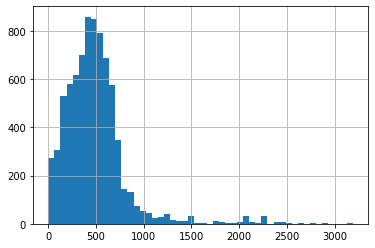

In [ ]:
data['parks_nearest'].hist(bins=50)

**Гистограмма распределения расстояний до парка.**

Большинство квартир расположены в 500-х м от парка, квартир далее 1 км от парка мало. Также заметное количество расположено в непосредственной близости от парка.

<AxesSubplot:>

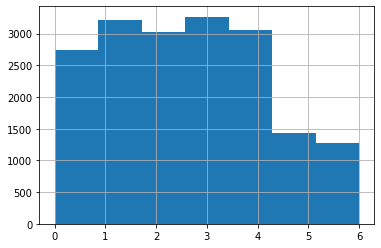

In [ ]:
data['day'].hist(bins=7)

**Гистограмма распределения дней недели.**

С понедельника по пятницу размещено примерно одинаковое количество объявлений о продаже. В выходные наблюдается спад размещения объявлений.

<AxesSubplot:>

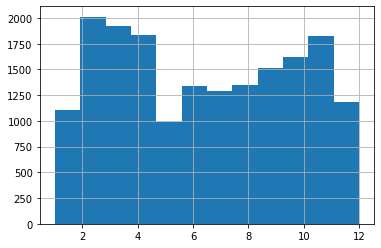

In [ ]:
data['month'].hist(bins=12)

**Гистограмма распределения месяцев.**

Пик на гистограмме приходится на февраль- апрель. В мае наблюдается резкое снижение количество объявлений, затем с июня снова начинается подъем и все заканчивается резким снижением в декабре.

#### Изучим, как быстро продавались квартиры.

<AxesSubplot:>

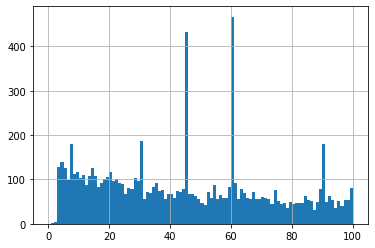

In [ ]:
# Изучим столбец с количеством дней, за которые продавались квартиры.
data['days_exposition'].hist(bins=100, range=(0, 100))

<div class="alert alert-info"> Большинство квартир продается за 1,5-2 месяца.
</div>

In [ ]:
print(data['days_exposition'].mean())
print(data['days_exposition'].median())


181.10047085772462
95.0


Большинство квартир продается за 3 месяца. Но также есть достаточно большое количество квартир проданных необычно быстро - менее чем за месяц.
Кроме того, некоторое количество квартир не продаются 2 года и больше.

<AxesSubplot:>

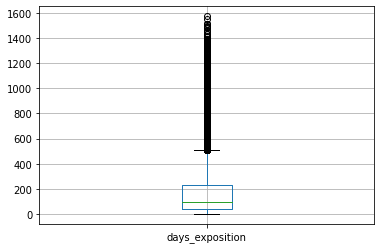

In [ ]:
data.boxplot('days_exposition')

<div class="alert alert-info"> Можно ли для оценки длительности продаж применить диаграмму размаха? Тогда необычно долгими можно считать объявления, провисевшие больше 230 дней. А за быстрые - взять первый квартиль, до 43 дней.
Или следует взять значения, выходящие за 1,5 межквартильных размаха? Тогда необычно долгими можно считать продажи более 500 дней. Но непонятно, какие считать необычайно короткими - межквартильный размах не выходит за 0.
Исходя из здравого смысла, я бы сказала, что быстрые продажи квартиры - меньше 14 дней.
</div>

In [ ]:
data['days_exposition'].describe()

count    15716.000000
mean       181.100471
std        221.565314
min          1.000000
25%         43.000000
50%         95.000000
75%        230.000000
max       1572.000000
Name: days_exposition, dtype: float64

#### Изучим, от каких факторов зависит стоимость квартир.

In [ ]:
# Посмотрим на столбец с ценами на квартиры.
print(data['last_price'].min())
print(data['last_price'].max())

1200000
98000000


In [ ]:
# Сгруппируем квартиры по цене.
def categorize_price(price):
    if price < 3000000:
        return 1
    if price < 5000000:
        return 2
    if price < 7000000:
        return 3
    if price < 10000000:
        return 4
    if price < 15000000:
        return 5
    return 6

data['price_category'] = data['last_price'].apply(categorize_price)
    

In [ ]:
# Посмотрим, как с возрастанием цены ведет себя общая площадь, жилая площадь, площадь кухни и количество комнат.
data.pivot_table(index='price_category', values=['total_area', 'living_area', 'kitchen_area', 'rooms'], aggfunc='median')

,kitchen_area,living_area,rooms,total_area
price_category,,,,
1,6.0,17.70,1,31.7
2,7.9,21.10,1,42.0
3,9.6,33.50,2,58.0
4,11.7,42.30,3,73.3
5,14.4,53.00,3,94.0
6,18.4,68.65,3,124.0


<AxesSubplot:xlabel='price_category'>

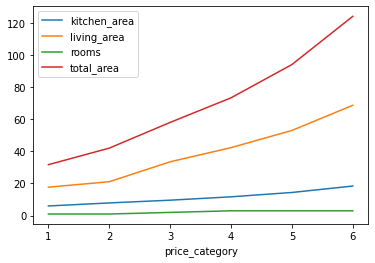

In [ ]:
(data
 .pivot_table(index='price_category', values=['total_area', 'living_area', 'kitchen_area', 'rooms'], aggfunc='median')
 .plot()
)
            

<AxesSubplot:xlabel='last_price', ylabel='rooms'>

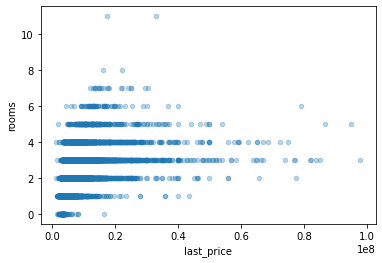

In [ ]:
# Посмотрим на количество комнат на диаграмме рассеяния.
data.plot(x='last_price', y='rooms', kind='scatter', alpha=0.3)

<AxesSubplot:xlabel='last_price', ylabel='kitchen_area'>

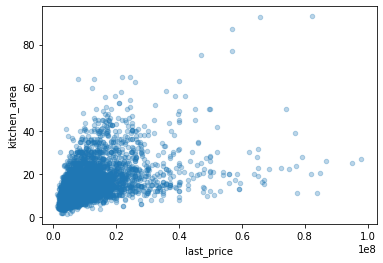

In [ ]:
# Посмотрим на площадь кухни на диаграмме рассеяния.
data.plot(x='last_price', y='kitchen_area', kind='scatter', alpha=0.3)

<AxesSubplot:xlabel='last_price', ylabel='living_area'>

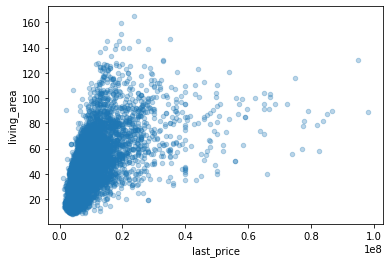

In [ ]:
# Посмотрим на жилую площадь на диаграмме рассеяния.
data.plot(x='last_price', y='living_area', kind='scatter', alpha=0.3)

<AxesSubplot:xlabel='last_price', ylabel='total_area'>

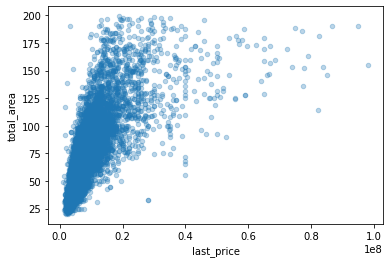

In [ ]:
# Посмотрим на общую площадь на диаграмме рассеяния.
data.plot(x='last_price', y='total_area', kind='scatter', alpha=0.3)

In [ ]:
# Посмотрим, как зависит стоимость квартиры от этажа.
data.pivot_table(index=['floor_type'], values='last_price', aggfunc='median')

,last_price
floor_type,
другой,5324000
первый,4600000
последний,5150000


<AxesSubplot:xlabel='floor_type'>

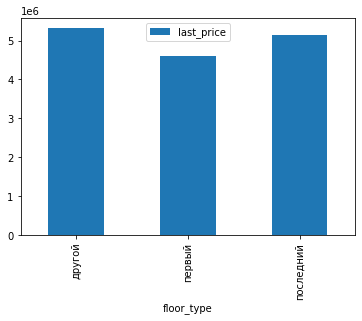

In [ ]:
data.pivot_table(index=['floor_type'], values='last_price', aggfunc='median').plot(kind='bar')

In [ ]:
# Посмотрим, как зависит стоимость от дня недели.
data.pivot_table(index='day', values='last_price', aggfunc='median')

,last_price
day,
0,5200000
1,5250000
2,5250000
3,5300000
4,5150000
5,5170000
6,5100000


<AxesSubplot:xlabel='day'>

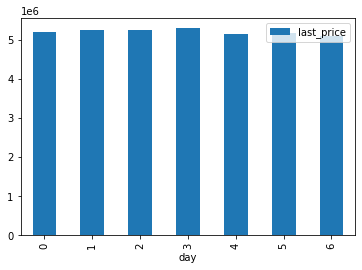

In [ ]:
# Посмотрим, как зависит стоимость от дня недели.
data.pivot_table(index='day', values='last_price', aggfunc='median').plot(kind='bar')

In [ ]:
# Посмотрим, как зависит стоимость от месяца.
data.pivot_table(index='month', values='last_price', aggfunc='median')

,last_price
month,
1,5300000
2,5200000
3,5300000
4,5300000
5,5100000
6,4990000
7,5190000
8,5200000
9,5250000


<AxesSubplot:xlabel='month'>

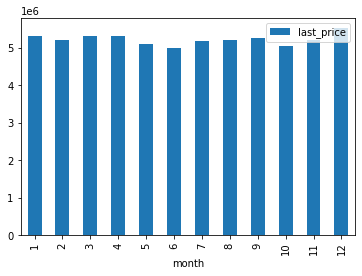

In [ ]:
data.pivot_table(index='month', values='last_price', aggfunc='median').plot(kind='bar')

In [ ]:
# Посмотрим, как зависит стоимость от года.
data.pivot_table(index='year', values='last_price', aggfunc='median')

,last_price
year,
2014,9150000
2015,5830000
2016,5097000
2017,5000000
2018,5200000
2019,5600000


In [ ]:
# В 2014 году наблюдается аномальное поднятие цены. Это странно, т.к. квартиры должны дорожать, особенно учитывая инфляцию.
# Добавим в сводную таблицу столбец с площадью квартир, возможно в 2014 году продавалось более дорогие квартиры с большой 
# площадью.
data.pivot_table(index='year', values=['last_price', 'total_area'], aggfunc='median')

,last_price,total_area
year,,
2014,9150000,80.0
2015,5830000,61.2
2016,5097000,55.0
2017,5000000,53.5
2018,5200000,52.0
2019,5600000,53.1


In [ ]:
# Для подтверждения выводов также посмотрим матрицу корреляции.
data.corr()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,studio,open_plan,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_1sqm,day,month,year,cityCenters_km,price_category
total_images,1.000000,0.127329,0.106133,0.083909,0.036985,0.012150,0.089861,0.030502,-0.022298,-0.012994,...,-0.005709,-0.016769,-0.000918,-0.034848,0.130662,-0.006561,0.006711,0.153425,-0.045723,0.168534
last_price,0.127329,1.000000,0.744999,0.452020,0.376280,-0.033082,0.642126,0.008323,-0.038933,-0.014086,...,-0.007292,0.204140,-0.112128,0.139030,0.754317,-0.008651,0.007117,-0.041088,-0.313823,0.777188
total_area,0.106133,0.744999,1.000000,0.786408,0.395454,-0.076008,0.931455,-0.033632,-0.075663,-0.037428,...,-0.007994,0.164469,-0.086044,0.177866,0.227601,-0.011787,0.008702,-0.088160,-0.243483,0.816158
rooms,0.083909,0.452020,0.786408,1.000000,0.224504,-0.238100,0.861721,-0.160281,-0.137978,-0.067795,...,-0.049420,0.080883,-0.042274,0.124876,-0.028939,-0.005328,-0.002652,-0.049109,-0.169354,0.577905
ceiling_height,0.036985,0.376280,0.395454,0.224504,1.000000,-0.116574,0.359957,-0.064664,0.017272,0.001056,...,-0.043372,0.186990,-0.109123,0.120504,0.285953,-0.025455,-0.000962,-0.062870,-0.337825,0.447765
floors_total,0.012150,-0.033082,-0.076008,-0.238100,-0.116574,1.000000,-0.182110,0.663872,0.064338,0.045741,...,0.095139,-0.118413,0.035293,-0.046094,0.065003,0.020491,0.006932,0.016827,0.009382,0.009474
living_area,0.089861,0.642126,0.931455,0.861721,0.359957,-0.182110,1.000000,-0.111007,-0.054455,-0.023320,...,-0.040995,0.142198,-0.066913,0.159816,0.132088,-0.008919,0.000622,-0.072679,-0.231341,0.724155
floor,0.030502,0.008323,-0.033632,-0.160281,-0.064664,0.663872,-0.111007,1.000000,0.031093,0.040043,...,0.072556,-0.075564,0.024657,-0.038370,0.076356,0.014749,0.010973,0.010598,0.004833,0.031513
studio,-0.022298,-0.038933,-0.075663,-0.137978,0.017272,0.064338,-0.054455,0.031093,1.000000,-0.003030,...,0.012897,-0.002416,-0.002190,-0.017571,0.021776,-0.001284,0.006739,0.007649,-0.006531,-0.057608
open_plan,-0.012994,-0.014086,-0.037428,-0.067795,0.001056,0.045741,-0.023320,0.040043,-0.003030,1.000000,...,0.011611,0.005878,-0.003329,-0.016754,0.012488,0.007813,0.014148,-0.016674,-0.001492,-0.034601


В результате изучения факторов, влияющих на цену картиры, получили следующие результаты.

Цены напрямую зависят от общей площади, чем больше площадь квартиры, она дороже. Корреляция этих факторов 74,5%.
Жилая площадь полностью зависит от общей и, в следствие этого, также оказывает влияние на стоимость, но уже в меньшей степени. Корреляция 64,3%.

Площадь кухни практически не оказывает влияния на цены квартир. Есть как недорогие квартиры с большими кухням, так и дорогие квартиры с маленькими кухнями.

Зависимость от количества комнат не выявлена. Кроме квартир-студий (квартиры с 0 комнат), такие квартиры есть только в недорогом сегменте.

Квартиры на 1-м этаже немного дешевле, чем на других этажах, включая последний. Но разница не очень существенная.

Кроме того, цены совсем не зависят от дня и месяца размещения объявления. Корреляция практически нулевая. Но стоит отметить, что в июне наблюдается небольшое снижение цен, а в декабре небольшое же их повышение.

Также не выявлена зависимость между стоимостью квартир и годом размещения объявления. В 2014 и 2015 годах медианная цена была несколько выше, но это можно оправдать большей площадью продаваемых квартир. С 2017 по 2019 можно замеить небольшой подъем цен, скорее всего это произошло из-за инфляции.


#### Посчитаем цену 1 кв.м в 10 населенных пунктах с наибольшим числом объявлений.

In [ ]:
big_ads_number = (data
           .pivot_table(index='locality_name', values='total_area', aggfunc='count').sort_values(by='total_area',
                                                                                                 ascending=False)
          )[:10]

big_ads_number.columns = ['count']
big_ads_number.join(data.pivot_table(index='locality_name', values='price_1sqm', aggfunc='median')).sort_values(by='price_1sqm',
                                                                                                             ascending=False)

,count,price_1sqm
locality_name,,
санкт-петербург,15445,104615.384615
пушкин,363,99987.179487
сестрорецк,182,99719.035988
поселок парголово,326,91780.224134
петергоф,200,82182.539683
кронштадт,95,81567.796610
поселок шушары,439,76829.268293
колпино,337,74722.222222
ломоносов,133,71875.000000


In [ ]:
print(data[data['price_1sqm'] == data['price_1sqm'].max()][['locality_name', 'price_1sqm']])
print()
print(data[data['price_1sqm'] == data['price_1sqm'].min()][['locality_name', 'price_1sqm']])

         locality_name     price_1sqm
4859   санкт-петербург  848484.848485
17172  санкт-петербург  848484.848485

         locality_name    price_1sqm
17753  санкт-петербург  15345.268542


Больше всего объявлений о продаже квартир в Санкт-Петербурге, поселке Шушары и Пушкине. При этом в Санкт-Петербурге и Пушкине самая большая средняя цена за квадратный метр, в Шушарах - цена ниже.

Самая высокая и самая низкая цены за 1 квадратный метр в Санкт-Петербурге. Возможно, это можно объяснить разницей в районах - дешевое жилье скорее всего расположено в плохом доме в непрестижном районе.

#### Вычислим среднюю цену 1 кв.м в Санкт-Петербурге по удаленности от центра. 

In [ ]:
(data
 .query('locality_name == "санкт-петербург"')
 .pivot_table(index='cityCenters_km', values='price_1sqm', aggfunc='mean')
)



,price_1sqm
cityCenters_km,
0.0,223446.081658
1.0,147397.712538
2.0,146870.617751
3.0,120520.523331
4.0,127963.913980
5.0,137096.306808
6.0,145180.493457
7.0,153249.426253
8.0,124055.793419


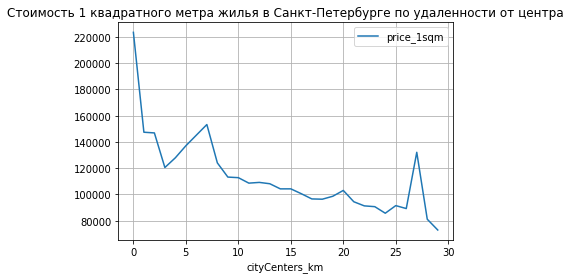

In [ ]:
(data
 .query('locality_name == "санкт-петербург"')
 .pivot_table(index='cityCenters_km', values='price_1sqm', aggfunc='mean')
 .plot(grid = True, title = 'Стоимость 1 квадратного метра жилья в Санкт-Петербурге по удаленности от центра')
);


Самая большая стоимость квадратного метра жилья, ожидаемо, в самом центре Санкт-Петербурга. Далее, по мере удаления от центра, цена за квадрат снижается, но в районе 7 км снова подскакивает - возможно, там располагается какой-то престижный район или хорошая застройка. Затем, стоимость квадратного метра все время снижается, но на 27 км присутствует всплеск - стоимость 1 кв.м близка к стоимости 1 кв.м на расстоянии 5 км от центра. Возможно, это можно объяснить теми же причинами, что и всплеск на 7 км.

### Общий вывод

**Постановка задачи.**
Имеются данные о продаже кварир в Санк-Петербурге и соседних населенных пунктах за несколько лет. Нужно изучить, какие факторы оказывают влияние на стоимость квартир. А также проанализировать стоимость 1 квадратного метра жилья.

**Гипотезы.**
* Цена квартиры зависит от общей площади.
* Цена квартиры зависит от жилой площади.
* Цена квартиры зависит от площади кухни.
* Цена квартиры зависит от количества комнат.
* Цена квартиры зависит от этажа, на котором расположена квартира.
* Цена квартиры зависит от даты размещения (день недели, месяц, год).

**Гипотеза 1 подтверждена.**

Цены на квартиры имеют прямую зависимость от площади квартиры. Коэффициент корреляции этих двух величин составляет 0,745.

**Гипотеза 2 подтверждена.**

Цены на квартиры имеют зависимость от жилой площади, но т.к. жилая площадь составляет часть общей площади, это влияние менее выражено. Коэффициент корреляции 0,643.

**Гипотеза 3 не подтверждена.**

Площадь кухни не влияет на цену квартиры. В выборке присутствуют и недорогие квартиры с большими кухням, и дорогие квартиры с маленькими кухнями.

**Гипотеза 4 не подтверждена.**

Количество комнат не влияет на цену квартиры. В выборке присутствуют и большие квартиры с 1 комнатой, и маленькие квартиры с 3 комнатами. Но квартиры-студии есть только в недорогом сегменте.

**Гипотеза 5 частично подтверждена.**

Цены на квартиры на 1-м этаже немного меньше, чем на других этажах. Цены на квартиры на последнем и других этажах различаются несущественно.

**Гипотеза 6 не подтверждена.**

Цены на квартиры не зависят от дня недели, месяца размещения объявления. Однако, стоит отметить некоторое снижение цен на квартиры в июне и повышение в декабре. 

Зависимость цен на квартиры от года размещения не выявлена. Коэффициент корреляции 0,152. Что касается изменения цен по годам, то некоторые вопросы вызывают высокие показатели в 2014 и 2015 годах - по логике цены на недвидимость должны расти, а не снижаться. Скорее всего, цены за эти годы объясняются увеличением средней площади продаваемых квартир. Дальше следует ожидаемое небольшое повышение стоимости, скорее всего в результате инфляции. 

Исходя из здравого смысла, одна и та же квартира, выставленная на продажу в 2019 году, будет стоить больше, чем выставленная в 2016 году. Возможно, природа зависимости от года - нелинейная.



**Оценка стоимости 1 квадратного метра жилья.**

Больше всего объявлений о продаже квартир в Санкт-Петербурге, поселке Шушары и Пушкине. При этом в Санкт-Петербурге и Пушкине самая большая средняя цена за квадратный метр, в Шушарах - цена ниже.

Самая высокая и самая низкая цены за 1 квадратный метр в Санкт-Петербурге. Возможно, это можно объяснить разницей в районах - дешевое жилье скорее всего расположено в плохом доме в непрестижном районе.


**Оценка зависимости стоимости 1 квадратного метра жилья по удаленности от центра в Санкт-Петербурге.**

Самая большая стоимость квадратного метра жилья, ожидаемо, в самом центре Санкт-Петербурга. Далее, по мере удаления от центра, цена за квадрат снижается, но в районе 7 км снова подскакивает - возможно, там располагается какой-то престижный район или хорошая застройка. Затем, стоимость квадратного метра все время снижается, но на 27 км присутствует всплеск - стоимость 1 кв.м близка к стоимости 1 кв.м на расстоянии 5 км от центра. Возможно, это можно объяснить теми же причинами, что и всплеск на 7 км.


В ходе исследования проведена предобработка данных - данные проверены на дубликаты и пропуски, заполнены пропущенные значения, удалены неявные дубликаты, а также редкие и аномальные значения. 
    Также в рамках исследовательского анализа данных изучены распределения значений показателей, медианные значения, определены взаимосвязи между различными характеристиками продаваемых квартир.